# Part 3.2 Building a model

In [1]:
from ipynb.fs.defs.p1_data_prep import load_dataset

In [2]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

## Loading the data

Load datasets training and test datasets.
We'll keep the test dataset aside for the very end to evaluate performance of the final model.

In [3]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)

Finished reading the dataset
Finished reading the dataset


We will keep 30% of test dataset for validation -  a.k.a validation dataset or dev set - and use it to tune the hyperparameters of the model.

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, \
y_train, y_val = train_test_split(x_train, y_train, 
                                  test_size=0.3, shuffle=True, 
                                  random_state=12)

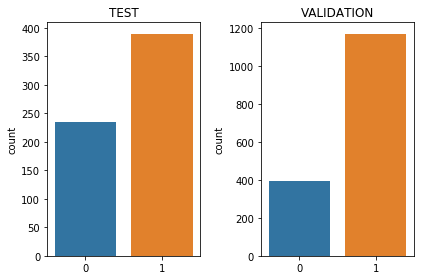

In [5]:
plt.subplot(1,2,1)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.subplot(1,2,2)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.tight_layout()

Example images from NORMAL and PNEUMONIA classes

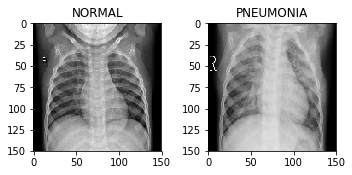

In [6]:
plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)])

plt.tight_layout()

## Model Architecture and Training

We're going to load VGG16 model with pre-trained ImageNet weights.

![](https://www.jeremyjordan.me/content/images/2018/04/vgg16.png)

Next, we'll replace the orignal classification layer and build a new one:)

It will be composed of:

- Flatten transformation that reshapes the MaxPool output (4 x 4 x 512) into (1 x 1 x 8192)
- Fully Connected Dense layer with Softmax activation function with 2 outputs (1 x 1 x 2)

Softmax function normalizes input vector into a probability distribution that sums to 1.0

In [7]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

K.clear_session()

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

This network has over 14M trainable wegihts.

In [8]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

We would like to train only the most bottom classifier layers.

In [9]:
for layer in model.layers[0:20]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: False
layer 20: dense_1, trainable: True
layer 21: batch_normalization_1, trainable: True
layer 22: dropout_1, trainable: True
layer 23: dense_2, trainable: True


In [10]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/gamma:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/beta:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 2) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(2,) dtype=float32_ref>]

By locking the trainable layers we decrease ammount of trainable parameters to 16'384.

Here we use the "cross-entropy" loss function, which works well for learning probability distributions for classification. 

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy

In [11]:
optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

In [13]:
from keras.callbacks import ReduceLROnPlateau

# This callback reduce learning rate when validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=5, min_lr=0.0001,
                              verbose=1)

The training set is un-balanaced. Let's calculate class weights

In [14]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.92970402 0.67486137]


In [25]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_datagen = image_data_generator(
  rescale = 1/255,
  rotation_range = 5,
  width_shift_range = 0.1,
  height_shift_range = 0.05,
  shear_range = 0.1,
  zoom_range = 0.15,
  horizontal_flip = TRUE,
  vertical_flip = FALSE,
  fill_mode = "reflect"
)

datagen.fit(x_train)

**Remark.** If you hit GPU OOM issues at this stage, make sure GPU resources are not grabbed by the previous Jupyter kernels -> Kill all the previous Jupyter kernels (eg. one you were using ) you were using for this excercise session. If nothing helps, try to restart Jupyter notebook.

In [29]:
# prepare a directory to store the model weights
os.makedirs('./model', exist_ok=True)

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train)/32,
    class_weight=classweight,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, reduce_lr],
    shuffle=True,
    epochs=20,
    verbose=1
)

Epoch 1/20
115/114 [==============================] - 21s 180ms/step - loss: 0.2829 - acc: 0.9092 - val_loss: 0.5613 - val_acc: 0.9163

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/20
115/114 [==============================] - 19s 165ms/step - loss: 0.1782 - acc: 0.9379 - val_loss: 1.4684 - val_acc: 0.8428

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/20
115/114 [==============================] - 19s 164ms/step - loss: 0.1601 - acc: 0.9433 - val_loss: 2.4645 - val_acc: 0.7840

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/20
115/114 [==============================] - 19s 165ms/step - loss: 0.1621 - acc: 0.9395 - val_loss: 3.6006 - val_acc: 0.7233

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/20
115/114 [==============================] - 19s 164ms/step - loss: 0.1251 - acc: 0.9576 - val_loss: 4.0565 - val_acc: 0.7131

Epoch 00005: saving model to model/weights.epoch_05.hdf5
Epoch 6/20
115/114 [===============

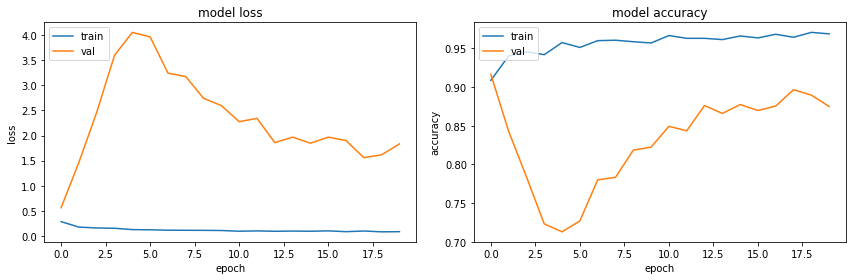

In [30]:
from model_diag import plot_learning_curves

plot_learning_curves(history)

**Restore the best model** - find an epoch with minimal Loss on the validation dataset

In [31]:
idx = np.argmin(history.history['val_loss']) 
model.load_weights("model/weights.epoch_{:02d}.hdf5".format(idx + 1))


print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

Loading the best model
epoch: 1, val_loss: 0.5612655033083446, val_acc: 0.9162939341875692


Measure Loss and Accuracy on the test dataset

In [32]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 0.563179078583534, Accuracy: 0.9134615384615384


Plot confusion matrix

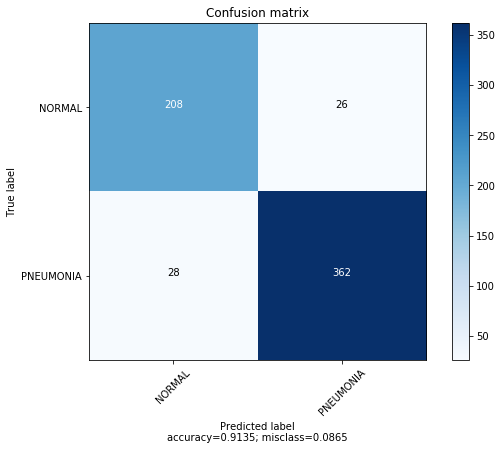

In [33]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

... and ROC curve

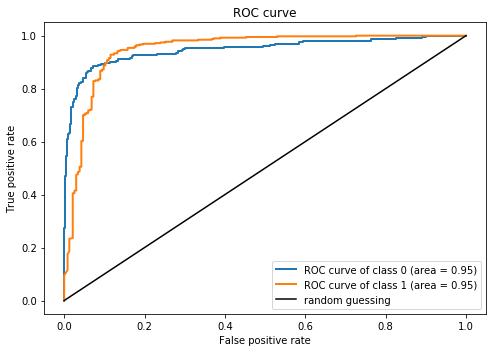

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

Let's check the performance metrics when the test set is ballanced (the same number of examples in both classes)

We need to under sample

(468, 67500)
(468,)
(468, 150, 150, 3)
(468, 2)


Text(0.5,1,'TEST (undersampled)')

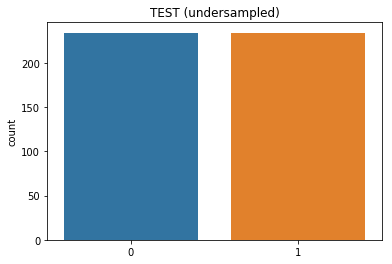

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical

rus = RandomUnderSampler(random_state=42)

x_test_flat_shape = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
x_test_flat = x_test.reshape(x_test.shape[0], x_test_flat_shape)

y_test_flat = np.argmax(y_test, axis=1)

x_res, y_res = rus.fit_resample(x_test_flat, y_test_flat)

print(x_res.shape)
print(y_res.shape)

y_test_rus = to_categorical(y_res, num_classes = 2)

for i in range(len(x_res)):
    height, width, channels = 150, 150, 3
    x_test_rus = x_res.reshape(len(x_res), height, width, channels)
    
print(x_test_rus.shape)
print(y_test_rus.shape)

sns.countplot(np.argmax(y_test_rus, axis=1)).set_title('TEST (undersampled)')

In [22]:
score = model.evaluate(x_test_rus, y_test_rus, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 1.1320217845409348, Accuracy: 0.7585470085470085


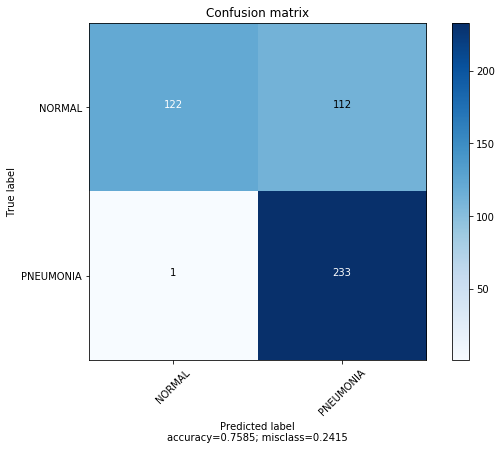

In [23]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test_rus)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test_rus, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

In 50:50 case the accuracy is lower

**Excercise 3.1.** We would like to achive a better performance on the test dataset. Try tuning hyperparameters i.e. learning rate. Can you reach better accuracy?

**Excercise 3.2.** Try to use another base network i.e. InceptionV3, ResNet50, DenseNet.

What do you observe? Is training time different? How many parameters does the function have?

**Excercise 3.3.** Try augmenting the training data using ImageDataGenerator from Keras. Introduce random rotation and image flips. Does this help?

**Excercise 3.4.** Try training some of the conv layers. Does this help?

**Excercise 3.5.** can you think about a better metric than accuracy, which captures the fact that false negatives are much (much) worse than false positives?